In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

import torchvision
from torchvision.transforms import v2 as tt
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

In [2]:
def accuracy(output, labels):
    _, preds = torch.max(output, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)).item()

def RMSE(output, labels):
    return torch.sqrt(torch.mean((output - labels) ** 2)).item()

def train(
    model,
    train_loader,
    valid_loader,
    optimizer,
    criterion,
    device,
    epochs=10,
    verbose=True,
    eval_metrics=[accuracy],
    label_idx=-1,
):

    eval_metric_names = [
        (
            eval_metric.__name__
            if (_ := eval_metric.__class__.__name__) == "function"
            else _
        )
        for eval_metric in eval_metrics
    ]

    history = {
        "train": {"loss": []},
        "valid": {"loss": []},
    }
    for eval_metric_name in eval_metric_names:
        history["train"][eval_metric_name] = []
        history["valid"][eval_metric_name] = []

    n = len(train_loader)
    model.to(device)
    for epoch in range(epochs):
        model.train()
        Loss_epoch = 0
        correct = {eval_metric_name: 0 for eval_metric_name in eval_metric_names}
        total = 0
        evaluation_train = {
            "loss": 0,
            **{eval_metric_name: 0 for eval_metric_name in eval_metric_names},
        }

        for idx, data in enumerate(tqdm(train_loader, disable=not verbose)):
            input, labels = data[0].to(device), data[label_idx].to(device)
            # print(input.shape, labels.shape)

            optimizer.zero_grad()
            output = model(input)
            loss = criterion(output, labels.float())
            loss.backward()
            optimizer.step()

            Loss_epoch += loss.item() * len(labels)

            for eval_metric, eval_metric_name in zip(eval_metrics, eval_metric_names):
                correct[eval_metric_name] += torch.tensor(
                    eval_metric(output, labels)
                ).item() * len(labels)
            total += len(labels)

        for eval_metric_name in eval_metric_names:
            evaluation_train[eval_metric_name] = correct[eval_metric_name] / total

        evaluation_train["loss"] = Loss_epoch / total
        evaluation_valid, *_ = evaluate(
            model,
            valid_loader,
            criterion,
            device,
            eval_metrics=eval_metrics,
            label_idx=label_idx,
        )
        if verbose:
            print(
                f"epoch: {epoch}, train: {evaluation_train}, valid: {evaluation_valid}"
            )

        for eval_metric_name in eval_metric_names:
            history["train"][eval_metric_name].append(
                evaluation_train[eval_metric_name]
            )
            history["valid"][eval_metric_name].append(
                evaluation_valid[eval_metric_name]
            )

        history["train"]["loss"].append(evaluation_train["loss"])
        history["valid"]["loss"].append(evaluation_valid["loss"])

    return history


def evaluate(
    model,
    data_loader,
    criterion,
    device,
    eval_metrics=[accuracy],
    return_preds=False,
    return_features=False,
    label_idx=-1,
):
    model.eval()
    eval_metric_names = [
        (
            eval_metric.__name__
            if (_ := eval_metric.__class__.__name__) == "function"
            else _
        )
        for eval_metric in eval_metrics
    ]
    metrics = {eval_metric_name: [] for eval_metric_name in eval_metric_names}
    Loss_history = []
    PREDS = []
    features = []
    ground_truth = []
    with torch.no_grad():
        for idx, data in enumerate(data_loader):
            input, target = data[0].to(device), data[label_idx].to(device)
            if return_features:
                output, feature = model(input, get_features=True)
                features.extend(feature.tolist())
            output = model(input)
            loss = criterion(output, target.float())

            for eval_metric, eval_metric_name in zip(eval_metrics, eval_metric_names):
                metrics[eval_metric_name].append(eval_metric(output, target))

            Loss_history.append(loss.item())
            if return_preds:

                PREDS.extend(output.tolist())
            ground_truth.extend(target.tolist())
    return (
        {
            **{
                eval_metric_name: torch.mean(
                    torch.Tensor(metrics[eval_metric_name])
                ).item()
                for eval_metric_name in eval_metric_names
            },
            "loss": torch.mean(torch.Tensor(Loss_history)).item(),
        },
        PREDS,
        features,
        ground_truth,
    )

In [3]:
# Define the base directory where images and ground truth data are stored

# Define the subdirectories for images and ground truth
import os


train_images = "./ISIC/train/"
train_masks = "./ISIC/train_masks/"
test_images = "./ISIC/test/"
test_masks = "./ISIC/test_masks/"
# Combine the base directory with subdirectories

# Get paths to the training and target images
train_image_paths = sorted(
    [
        os.path.join(train_images, fname)
        for fname in os.listdir(train_images)
        if fname.endswith(".jpg")
    ]
)
train_masks_paths = sorted(
    [
        os.path.join(train_masks, fname)
        for fname in os.listdir(train_masks)
        if fname.endswith(".png")
    ]
)


# Split your data into training, validation, and test sets
train_image_paths, val_image_paths, train_masks_paths, val_masks_paths = (
    train_test_split(
        train_image_paths, train_masks_paths, test_size=0.2, random_state=32
    )
)


test_image_paths = sorted(
    [
        os.path.join(test_images, fname)
        for fname in os.listdir(test_images)
        if fname.endswith(".jpg")
    ]
)
test_masks_paths = sorted(
    [
        os.path.join(test_masks, fname)
        for fname in os.listdir(test_masks)
        if fname.endswith(".png")
    ]
)

# Check if dimensions are equal
print("Number of samples in the train image folder:", len(train_image_paths))
print("Number of samples in the train  mask folder:", len(train_masks_paths))
print("Number of samples in the test image folder:", len(test_image_paths))
print("Number of samples in the test mask folder:", len(test_masks_paths))

Number of samples in the train image folder: 720
Number of samples in the train  mask folder: 720
Number of samples in the test image folder: 379
Number of samples in the test mask folder: 379


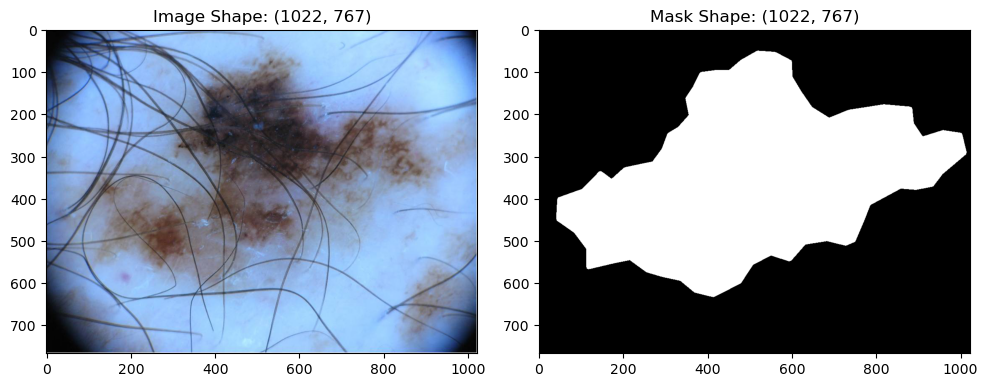

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

# Define the paths to your image and segmentation mask
image_path = train_image_paths[0]
mask_path = train_masks_paths[0]

# Open the image and mask using Pillow
image = Image.open(image_path)
mask = Image.open(mask_path)

# Get the dimensions (shape) of the image and mask
image_shape = image.size  # Returns (width, height)
mask_shape = mask.size  # Returns (width, height)

# Convert the image and mask to NumPy arrays for visualization
image_array = plt.imread(image_path)
mask_array = plt.imread(mask_path)

# Plot the image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_array)
plt.title(f"Image Shape: {image_shape}")

# Plot the mask
plt.subplot(1, 2, 2)
plt.imshow(mask_array, cmap="gray")  # Assuming the mask is grayscale
plt.title(f"Mask Shape: {mask_shape}")

# Show the plots
plt.tight_layout()
plt.show()

In [5]:
class ISICDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        img = Image.open(image_path)
        mask = Image.open(mask_path)

        img = np.array(img)
        mask = np.array(mask)
        mask[mask == 255.0] = 1.0

        if self.transform:
            augmentations = self.transform(image=img, mask=mask)
            img = augmentations["image"]
            mask = augmentations["mask"]
            mask = torch.unsqueeze(mask, 0)
            # mask = mask.float()

        return img, mask

    def __len__(self):
        return len(self.image_paths)

In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


train_transform = A.Compose(
    [
        A.Resize(128, 128),
        A.Rotate(limit=25, p=0.1),
        A.HorizontalFlip(p=0.3),
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255),
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(128, 128),
        A.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255),
        ToTensorV2(),
    ]
)

In [7]:
train_data = ISICDataset(
    train_image_paths, train_masks_paths, transform=train_transform
)
val_data  = ISICDataset(val_image_paths, val_masks_paths, transform=test_transform)
test_data  = ISICDataset(test_image_paths, test_masks_paths, transform=test_transform)

In [8]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [15]:
from torchvision import models


class SimpleSegmentationNet(nn.Module):
    def __init__(self, finetune=False):
        super().__init__()
        self.feature_extractor = models.mobilenet_v2(pretrained=True).features
        if not finetune:
            for parma in self.feature_extractor.parameters():
                parma.requires_grad = False

        self.seg_mask = nn.Sequential(
            nn.ConvTranspose2d(
                1280,
                512,
                kernel_size=2,
                stride=2,
            ),
            nn.ReLU(),
            
            nn.Conv2d(512, 256, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=2),
            nn.ReLU(),
            
            nn.ConvTranspose2d(
                256,
                128,
                kernel_size=2,
                stride=2,
            ),
            nn.ReLU(),

            
            nn.Conv2d(128, 64, kernel_size=3, padding=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=2),
            nn.ReLU(),


            nn.ConvTranspose2d(
                64,
                32,
                kernel_size=2,
                stride=2,
            ),
            nn.ReLU(),

            nn.Conv2d(32, 16, kernel_size=3, padding=3),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=3),
            nn.ReLU(),


            nn.ConvTranspose2d(
                16,
                16,
                kernel_size=2,
                stride=2,
            ),

            nn.Conv2d(16, 1, kernel_size=1),
            nn.Sigmoid(),

        )

    def forward(self, x):
        x = self.feature_extractor(x)
        seg_mask = self.seg_mask(x)
        return seg_mask

In [16]:
from torchmetrics import JaccardIndex
from torchmetrics.functional import dice

# Q1

In [18]:
epochs = 15
model = SimpleSegmentationNet(finetune=False)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
history = train(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    epochs=epochs,
    verbose=True,
    eval_metrics=[RMSE,dice,JaccardIndex(task='binary').to(device)],
    label_idx=-1,
)
evaluation_test, test_preds, _, test_labels = evaluate(
    model,
    test_loader,
    criterion,
    device,
    eval_metrics=[RMSE,dice,JaccardIndex(task='binary').to(device)],
    return_preds=True,
    label_idx=-1,
)

  0%|          | 0/23 [00:00<?, ?it/s]C:\Users\KHADGA JYOTH ALLI\AppData\Local\Temp\ipykernel_4216\1453601988.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct[eval_metric_name] += torch.tensor(
100%|██████████| 23/23 [00:36<00:00,  1.57s/it]


epoch: 0, train: {'loss': 0.6105510069264306, 'RMSE': 0.45300624900394015, 'dice': 0.07724832933810022, 'BinaryJaccardIndex': 0.04953093199680249}, valid: {'RMSE': 0.39307424426078796, 'dice': 0.0, 'BinaryJaccardIndex': 0.0, 'loss': 0.4647357761859894}


100%|██████████| 23/23 [00:35<00:00,  1.56s/it]


epoch: 1, train: {'loss': 0.4626383900642395, 'RMSE': 0.3911437670389811, 'dice': 0.0, 'BinaryJaccardIndex': 0.0}, valid: {'RMSE': 0.3809220492839813, 'dice': 0.0, 'BinaryJaccardIndex': 0.0, 'loss': 0.4421566426753998}


100%|██████████| 23/23 [00:36<00:00,  1.57s/it]


epoch: 2, train: {'loss': 0.3935759087403615, 'RMSE': 0.35589492122332256, 'dice': 0.4325695236523946, 'BinaryJaccardIndex': 0.33952625195185343}, valid: {'RMSE': 0.32634761929512024, 'dice': 0.7483718395233154, 'BinaryJaccardIndex': 0.5981321930885315, 'loss': 0.3406575918197632}


100%|██████████| 23/23 [00:36<00:00,  1.58s/it]


epoch: 3, train: {'loss': 0.3465537495083279, 'RMSE': 0.3273393803172641, 'dice': 0.7533987455897861, 'BinaryJaccardIndex': 0.6053299850887722}, valid: {'RMSE': 0.3398866355419159, 'dice': 0.7185809016227722, 'BinaryJaccardIndex': 0.5609210133552551, 'loss': 0.36833909153938293}


100%|██████████| 23/23 [00:36<00:00,  1.59s/it]


epoch: 4, train: {'loss': 0.3325080222553677, 'RMSE': 0.31783082087834674, 'dice': 0.7521561251746284, 'BinaryJaccardIndex': 0.604804782072703}, valid: {'RMSE': 0.3052525818347931, 'dice': 0.7319457530975342, 'BinaryJaccardIndex': 0.5773724317550659, 'loss': 0.3182069659233093}


100%|██████████| 23/23 [00:36<00:00,  1.57s/it]


epoch: 5, train: {'loss': 0.30183729926745095, 'RMSE': 0.3009798546632131, 'dice': 0.7751886394288805, 'BinaryJaccardIndex': 0.6335780792766147}, valid: {'RMSE': 0.2895253896713257, 'dice': 0.7684502601623535, 'BinaryJaccardIndex': 0.6242386698722839, 'loss': 0.2801038324832916}


100%|██████████| 23/23 [00:35<00:00,  1.56s/it]


epoch: 6, train: {'loss': 0.2890866392188602, 'RMSE': 0.2946758574909634, 'dice': 0.7808765848477681, 'BinaryJaccardIndex': 0.6411984046300252}, valid: {'RMSE': 0.2976756989955902, 'dice': 0.7288601994514465, 'BinaryJaccardIndex': 0.5735811591148376, 'loss': 0.30200713872909546}


100%|██████████| 23/23 [00:35<00:00,  1.55s/it]


epoch: 7, train: {'loss': 0.2803112513489193, 'RMSE': 0.28964992430475023, 'dice': 0.7857191363970438, 'BinaryJaccardIndex': 0.6478513068623013}, valid: {'RMSE': 0.3052428066730499, 'dice': 0.6980839371681213, 'BinaryJaccardIndex': 0.5366142988204956, 'loss': 0.3165872097015381}


100%|██████████| 23/23 [00:36<00:00,  1.57s/it]


epoch: 8, train: {'loss': 0.26604200204213463, 'RMSE': 0.2823381476932102, 'dice': 0.794057219558292, 'BinaryJaccardIndex': 0.6591394623120626}, valid: {'RMSE': 0.2807713449001312, 'dice': 0.7693526148796082, 'BinaryJaccardIndex': 0.6254352927207947, 'loss': 0.2599237263202667}


100%|██████████| 23/23 [00:35<00:00,  1.55s/it]


epoch: 9, train: {'loss': 0.26387530631489226, 'RMSE': 0.2812424408064948, 'dice': 0.7937091151873271, 'BinaryJaccardIndex': 0.659185078408983}, valid: {'RMSE': 0.29880136251449585, 'dice': 0.703838050365448, 'BinaryJaccardIndex': 0.5433005690574646, 'loss': 0.29918375611305237}


100%|██████████| 23/23 [00:35<00:00,  1.55s/it]


epoch: 10, train: {'loss': 0.25753739145067, 'RMSE': 0.279110723733902, 'dice': 0.7943934771749709, 'BinaryJaccardIndex': 0.6597523344887628}, valid: {'RMSE': 0.2822696268558502, 'dice': 0.7553625106811523, 'BinaryJaccardIndex': 0.6074039340019226, 'loss': 0.26649463176727295}


100%|██████████| 23/23 [00:35<00:00,  1.55s/it]


epoch: 11, train: {'loss': 0.25814750293890637, 'RMSE': 0.2788075202041202, 'dice': 0.7976602647039626, 'BinaryJaccardIndex': 0.6644852333598666}, valid: {'RMSE': 0.2804381549358368, 'dice': 0.767801821231842, 'BinaryJaccardIndex': 0.6233550906181335, 'loss': 0.2693089544773102}


100%|██████████| 23/23 [00:35<00:00,  1.55s/it]


epoch: 12, train: {'loss': 0.2678722355100844, 'RMSE': 0.2842790053950416, 'dice': 0.7865802937083775, 'BinaryJaccardIndex': 0.6497764309247335}, valid: {'RMSE': 0.27689188718795776, 'dice': 0.781996488571167, 'BinaryJaccardIndex': 0.642227828502655, 'loss': 0.25463351607322693}


100%|██████████| 23/23 [00:35<00:00,  1.55s/it]


epoch: 13, train: {'loss': 0.2520040697521634, 'RMSE': 0.2736246175236172, 'dice': 0.8031806906064352, 'BinaryJaccardIndex': 0.6719926383760241}, valid: {'RMSE': 0.2879648804664612, 'dice': 0.773693859577179, 'BinaryJaccardIndex': 0.6314060688018799, 'loss': 0.27526286244392395}


100%|██████████| 23/23 [00:35<00:00,  1.56s/it]


epoch: 14, train: {'loss': 0.28173513147566054, 'RMSE': 0.2923844575881958, 'dice': 0.7738685568173727, 'BinaryJaccardIndex': 0.6332711219787598}, valid: {'RMSE': 0.2921704649925232, 'dice': 0.7175071835517883, 'BinaryJaccardIndex': 0.5601758360862732, 'loss': 0.28618180751800537}


In [19]:
print(evaluation_test)

{'RMSE': 0.3028581440448761, 'dice': 0.7109711170196533, 'BinaryJaccardIndex': 0.5541931390762329, 'loss': 0.3036652207374573}


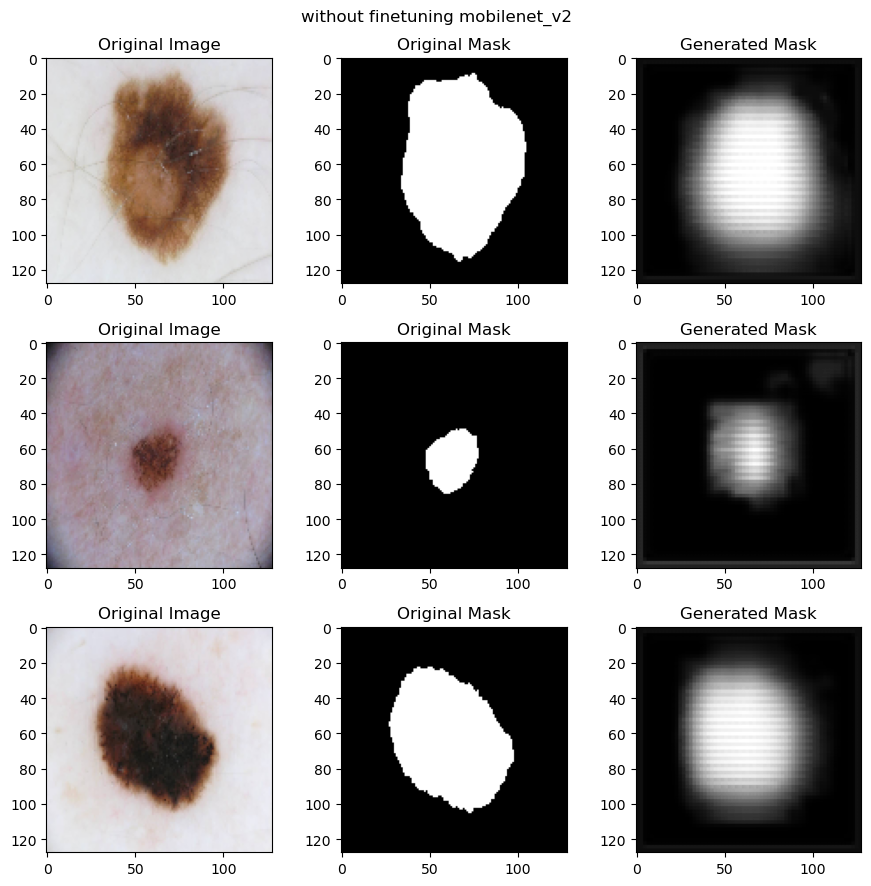

In [20]:
imgs, masks = next(iter(test_loader))
outputs = model(imgs.cuda())
outputs = outputs.detach().cpu().numpy()
num_images = 3
plt.figure(figsize=(9, num_images*3 )) 

i = 1
for img, mask, output in zip(imgs, masks, outputs): 
    plt.subplot(num_images, 3, i)
    plt.imshow(img.permute(1,2,0))
    plt.title("Original Image")
    i += 1

    plt.subplot(num_images, 3, i)
    plt.imshow(mask.squeeze(), cmap="gray")
    plt.title("Original Mask")
    i += 1

    plt.subplot(num_images, 3, i)
    plt.imshow(output.squeeze(), cmap="gray") 
    plt.title("Generated Mask")
    i += 1

    if i>3*num_images:
        break

plt.suptitle("without finetuning mobilenet_v2")
plt.tight_layout()
plt.show()



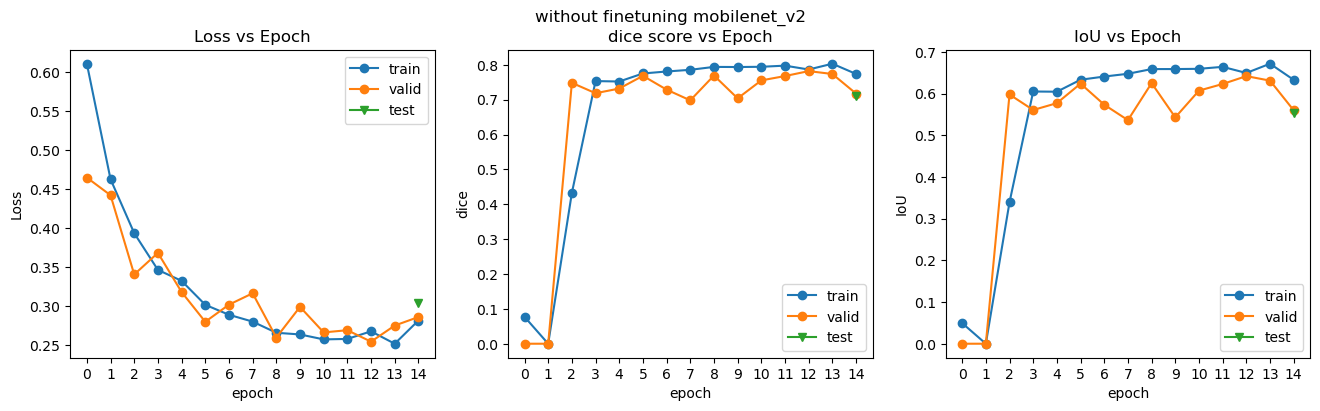

In [21]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.plot(history['train']['loss'],'-o', label='train')
plt.plot(history['valid']['loss'],'-o',label='valid')
plt.plot(epochs-1,evaluation_test['loss'],label = 'test',marker = 'v',ms = 6)

plt.legend()
plt.title('Loss vs Epoch')
plt.xlabel("epoch")
plt.ylabel('Loss')
plt.xticks(range(epochs))
# plt.show()


plt.subplot(1, 3, 2)
plt.plot(history['train']['dice'],'-o', label='train')
plt.plot(history['valid']['dice'],'-o',label='valid')
plt.plot(epochs-1,evaluation_test['dice'],label = 'test',marker = 'v',ms = 6)

plt.legend()
plt.title('dice score vs Epoch')
plt.xlabel("epoch")
plt.ylabel('dice')
plt.xticks(range(epochs))
# plt.show()

plt.subplot(1, 3, 3)
plt.plot(history['train']['BinaryJaccardIndex'],'-o', label='train')
plt.plot(history['valid']['BinaryJaccardIndex'],'-o',label='valid')
plt.plot(epochs-1,evaluation_test['BinaryJaccardIndex'],label = 'test',marker = 'v',ms = 6)

plt.legend()
plt.title('IoU vs Epoch')
plt.xlabel("epoch")
plt.ylabel('IoU')
plt.xticks(range(epochs))
plt.suptitle("without finetuning mobilenet_v2")
plt.show()

# Q2

In [22]:
epochs = 15
model = SimpleSegmentationNet(finetune=True)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCELoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
history = train(
    model,
    train_loader,
    val_loader,
    optimizer,
    criterion,
    device,
    epochs=epochs,
    verbose=True,
    eval_metrics=[RMSE,dice,JaccardIndex(task='binary').to(device)],
    label_idx=-1,
)
evaluation_test, test_preds, _, test_labels = evaluate(
    model,
    test_loader,
    criterion,
    device,
    eval_metrics=[RMSE,dice,JaccardIndex(task='binary').to(device)],
    return_preds=True,
    label_idx=-1,
)

  0%|          | 0/23 [00:00<?, ?it/s]C:\Users\KHADGA JYOTH ALLI\AppData\Local\Temp\ipykernel_4216\1453601988.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  correct[eval_metric_name] += torch.tensor(
100%|██████████| 23/23 [00:35<00:00,  1.56s/it]


epoch: 0, train: {'loss': 0.7399916768074035, 'RMSE': 0.522817067305247, 'dice': 0.431053900718689, 'BinaryJaccardIndex': 0.2757918463812934}, valid: {'RMSE': 0.5240086913108826, 'dice': 0.40226563811302185, 'BinaryJaccardIndex': 0.25244465470314026, 'loss': 0.7424736022949219}


100%|██████████| 23/23 [00:35<00:00,  1.56s/it]


epoch: 1, train: {'loss': 0.7334284901618957, 'RMSE': 0.5197964482837253, 'dice': 0.4298764295048184, 'BinaryJaccardIndex': 0.27472132245699565}, valid: {'RMSE': 0.5101819038391113, 'dice': 0.38773074746131897, 'BinaryJaccardIndex': 0.24107027053833008, 'loss': 0.7068349719047546}


100%|██████████| 23/23 [00:35<00:00,  1.55s/it]


epoch: 2, train: {'loss': 0.6731556097666422, 'RMSE': 0.49718065725432503, 'dice': 0.42950885362095303, 'BinaryJaccardIndex': 0.2745247662067413}, valid: {'RMSE': 0.49517348408699036, 'dice': 0.40174874663352966, 'BinaryJaccardIndex': 0.2520388066768646, 'loss': 0.666898787021637}


100%|██████████| 23/23 [00:35<00:00,  1.55s/it]


epoch: 3, train: {'loss': 0.6477580388387044, 'RMSE': 0.48757301701439754, 'dice': 0.42739915781550936, 'BinaryJaccardIndex': 0.27266272008419035}, valid: {'RMSE': 0.49075424671173096, 'dice': 0.3999301493167877, 'BinaryJaccardIndex': 0.25060734152793884, 'loss': 0.6549515724182129}


100%|██████████| 23/23 [00:35<00:00,  1.54s/it]


epoch: 4, train: {'loss': 0.6331366221110026, 'RMSE': 0.48123949633704294, 'dice': 0.42464424967765807, 'BinaryJaccardIndex': 0.2703886416223314}, valid: {'RMSE': 0.4791622459888458, 'dice': 0.40438029170036316, 'BinaryJaccardIndex': 0.2539965808391571, 'loss': 0.6334962844848633}


100%|██████████| 23/23 [00:35<00:00,  1.54s/it]


epoch: 5, train: {'loss': 0.6038769364356995, 'RMSE': 0.46543646256128945, 'dice': 0.44284379482269287, 'BinaryJaccardIndex': 0.28538399471176995}, valid: {'RMSE': 0.4706059694290161, 'dice': 0.46820923686027527, 'BinaryJaccardIndex': 0.3063192069530487, 'loss': 0.6238531470298767}


100%|██████████| 23/23 [00:35<00:00,  1.54s/it]


epoch: 6, train: {'loss': 0.5469586200184292, 'RMSE': 0.43349480628967285, 'dice': 0.5275676038530138, 'BinaryJaccardIndex': 0.3590683294667138}, valid: {'RMSE': 0.39655759930610657, 'dice': 0.5632067918777466, 'BinaryJaccardIndex': 0.3923623561859131, 'loss': 0.47050273418426514}


100%|██████████| 23/23 [00:35<00:00,  1.54s/it]


epoch: 7, train: {'loss': 0.44776634242799546, 'RMSE': 0.3815162228213416, 'dice': 0.5991547385851542, 'BinaryJaccardIndex': 0.4284384071826935}, valid: {'RMSE': 0.3414898216724396, 'dice': 0.6317818760871887, 'BinaryJaccardIndex': 0.4619961678981781, 'loss': 0.3653057813644409}


100%|██████████| 23/23 [00:34<00:00,  1.52s/it]


epoch: 8, train: {'loss': 0.3732418384816911, 'RMSE': 0.34872702956199647, 'dice': 0.6412687195671929, 'BinaryJaccardIndex': 0.4723371260695987}, valid: {'RMSE': 0.32270094752311707, 'dice': 0.6371288895606995, 'BinaryJaccardIndex': 0.4676954746246338, 'loss': 0.3233925402164459}


100%|██████████| 23/23 [00:35<00:00,  1.54s/it]


epoch: 9, train: {'loss': 0.3266888664828406, 'RMSE': 0.3271036254035102, 'dice': 0.662520334455702, 'BinaryJaccardIndex': 0.4956908298863305}, valid: {'RMSE': 0.3092825412750244, 'dice': 0.6642196774482727, 'BinaryJaccardIndex': 0.4974668025970459, 'loss': 0.2930516004562378}


100%|██████████| 23/23 [00:35<00:00,  1.55s/it]


epoch: 10, train: {'loss': 0.2967441029018826, 'RMSE': 0.31184967425134447, 'dice': 0.677233076095581, 'BinaryJaccardIndex': 0.5125074028968811}, valid: {'RMSE': 0.30248746275901794, 'dice': 0.6574985384941101, 'BinaryJaccardIndex': 0.49001339077949524, 'loss': 0.28198981285095215}


100%|██████████| 23/23 [00:35<00:00,  1.56s/it]


epoch: 11, train: {'loss': 0.2713771575027042, 'RMSE': 0.2992967473136054, 'dice': 0.6958418011665344, 'BinaryJaccardIndex': 0.5337700194782681}, valid: {'RMSE': 0.29429933428764343, 'dice': 0.6932950615882874, 'BinaryJaccardIndex': 0.5308689475059509, 'loss': 0.2663966119289398}


100%|██████████| 23/23 [00:35<00:00,  1.54s/it]


epoch: 12, train: {'loss': 0.25972262852721745, 'RMSE': 0.2921487662527296, 'dice': 0.7054666916529337, 'BinaryJaccardIndex': 0.5452939417627123}, valid: {'RMSE': 0.28358957171440125, 'dice': 0.6947384476661682, 'BinaryJaccardIndex': 0.5325453281402588, 'loss': 0.2430911809206009}


100%|██████████| 23/23 [00:35<00:00,  1.53s/it]


epoch: 13, train: {'loss': 0.24897738562689886, 'RMSE': 0.2862713827027215, 'dice': 0.714092825518714, 'BinaryJaccardIndex': 0.555652646223704}, valid: {'RMSE': 0.28321707248687744, 'dice': 0.69388347864151, 'BinaryJaccardIndex': 0.5315406918525696, 'loss': 0.2458658218383789}


100%|██████████| 23/23 [00:35<00:00,  1.56s/it]


epoch: 14, train: {'loss': 0.23881759378645157, 'RMSE': 0.28075025147861904, 'dice': 0.718031112353007, 'BinaryJaccardIndex': 0.5604926652378506}, valid: {'RMSE': 0.27760884165763855, 'dice': 0.7077066898345947, 'BinaryJaccardIndex': 0.5479837656021118, 'loss': 0.23395808041095734}


In [25]:
print(evaluation_test)

{'RMSE': 0.2888067066669464, 'dice': 0.7075188159942627, 'BinaryJaccardIndex': 0.5507399439811707, 'loss': 0.2616024911403656}


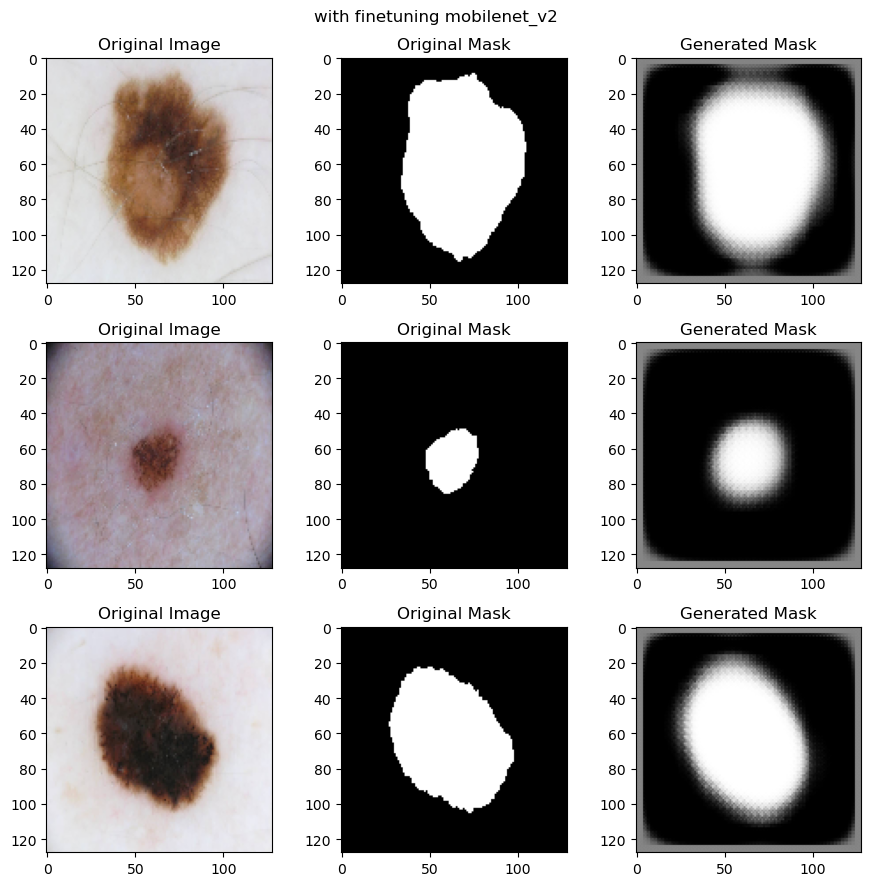

In [26]:
imgs, masks = next(iter(test_loader))
outputs = model(imgs.cuda())
outputs = outputs.detach().cpu().numpy()
num_images = 3
plt.figure(figsize=(9, num_images*3 )) 

i = 1
for img, mask, output in zip(imgs, masks, outputs): 
    plt.subplot(num_images, 3, i)
    plt.imshow(img.permute(1,2,0))
    plt.title("Original Image")
    i += 1

    plt.subplot(num_images, 3, i)
    plt.imshow(mask.squeeze(), cmap="gray")
    plt.title("Original Mask")
    i += 1

    plt.subplot(num_images, 3, i)
    plt.imshow(output.squeeze(), cmap="gray") 
    plt.title("Generated Mask")
    i += 1

    if i>3*num_images:
        break

plt.suptitle("with finetuning mobilenet_v2")
plt.tight_layout()
plt.show()



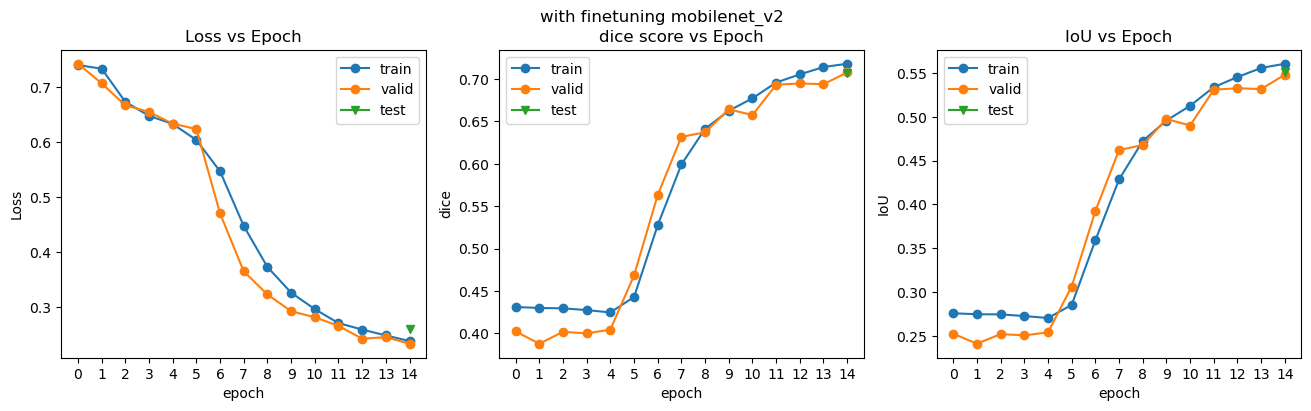

In [27]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.plot(history['train']['loss'],'-o', label='train')
plt.plot(history['valid']['loss'],'-o',label='valid')
plt.plot(epochs-1,evaluation_test['loss'],label = 'test',marker = 'v',ms = 6)

plt.legend()
plt.title('Loss vs Epoch')
plt.xlabel("epoch")
plt.ylabel('Loss')
plt.xticks(range(epochs))
# plt.show()


plt.subplot(1, 3, 2)
plt.plot(history['train']['dice'],'-o', label='train')
plt.plot(history['valid']['dice'],'-o',label='valid')
plt.plot(epochs-1,evaluation_test['dice'],label = 'test',marker = 'v',ms = 6)

plt.legend()
plt.title('dice score vs Epoch')
plt.xlabel("epoch")
plt.ylabel('dice')
plt.xticks(range(epochs))
# plt.show()

plt.subplot(1, 3, 3)
plt.plot(history['train']['BinaryJaccardIndex'],'-o', label='train')
plt.plot(history['valid']['BinaryJaccardIndex'],'-o',label='valid')
plt.plot(epochs-1,evaluation_test['BinaryJaccardIndex'],label = 'test',marker = 'v',ms = 6)

plt.legend()
plt.title('IoU vs Epoch')
plt.xlabel("epoch")
plt.ylabel('IoU')
plt.xticks(range(epochs))
plt.suptitle("with finetuning mobilenet_v2")
plt.show()